In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
from qlstm_pennylane import QLSTM


# preprocessing

In [2]:
df_half_hour=pd.read_csv('daily_max_temp_phx.csv')
df_half_hour.isna().sum()

dwpf      0
relh      0
drct      0
sknt      0
alti      0
mslp      0
vsby      0
temp_c    0
dtype: int64

In [3]:
daily_max_temp=df_half_hour
daily_max_temp

,dwpf,relh,drct,sknt,alti,mslp,vsby,temp_c
0,10.0,10.30,0.0,0.0,30.12,1019.3,10.0,20.000000
1,17.0,13.10,0.0,3.0,30.01,1015.3,10.0,21.111111
2,20.0,14.29,290.0,3.0,30.05,1016.8,10.0,21.666667
3,17.0,11.81,80.0,8.0,30.07,1017.2,10.0,22.777778
4,21.0,14.51,0.0,0.0,30.02,1015.8,10.0,22.222222
...,...,...,...,...,...,...,...,...
5403,32.0,11.19,300.0,14.0,29.73,1006.4,10.0,34.444444
5404,42.0,20.68,300.0,5.0,29.66,1002.7,10.0,30.555556
5405,35.0,24.87,200.0,4.0,30.03,1015.8,10.0,22.777778
5406,32.0,16.92,310.0,6.0,30.07,1016.9,10.0,27.222222


In [4]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 42.22222222222222


,dwpf,relh,drct,sknt,alti,mslp,vsby,temp_c
0,10.0,10.30,0.0,0.0,30.12,1019.3,10.0,20.000000
1,17.0,13.10,0.0,3.0,30.01,1015.3,10.0,21.111111
2,20.0,14.29,290.0,3.0,30.05,1016.8,10.0,21.666667
3,17.0,11.81,80.0,8.0,30.07,1017.2,10.0,22.777778
4,21.0,14.51,0.0,0.0,30.02,1015.8,10.0,22.222222
...,...,...,...,...,...,...,...,...
5403,32.0,11.19,300.0,14.0,29.73,1006.4,10.0,34.444444
5404,42.0,20.68,300.0,5.0,29.66,1002.7,10.0,30.555556
5405,35.0,24.87,200.0,4.0,30.03,1015.8,10.0,22.777778
5406,32.0,16.92,310.0,6.0,30.07,1016.9,10.0,27.222222


# some functions needed

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Normalize data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Build and compile LSTM model
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(input_shape[-1]))  # Output neurons equal to feature count
    
    # Create the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model

# Function to plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()

def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    model.eval()  # Set model to evaluation mode
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []

        for i in range(n_samples - step + 1):
            sequence = x_test[i]  # Shape: (seq_len, n_features)

            # Perform recursive prediction for t in [0, step-1)
            for t in range(step - 1):
                input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)  # Add batch dimension
                with torch.no_grad():
                    prediction = model(input_tensor)
                prediction = prediction.numpy().reshape(1, n_features)
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for current step
            input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)
            with torch.no_grad():
                final_prediction = model(input_tensor)

            final_prediction_np = final_prediction.numpy()
            predictions.append(final_prediction_np[0])  # shape: (n_features,)

        # Inverse transform and reshape
        predictions = scaler.inverse_transform(np.array(predictions))
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict





# try traning each function alone.


🔁 Training model for: dwpf
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.1062
Epoch 20/300, Loss: 0.1018
Epoch 30/300, Loss: 0.0968
Epoch 40/300, Loss: 0.0846
Epoch 50/300, Loss: 0.0659
Epoch 60/300, Loss: 0.0433
Epoch 70/300, Loss: 0.0320
Epoch 80/300, Loss: 0.0330
Epoch 90/300, Loss: 0.0317
Epoch 100/300, Loss: 0.0314
Epoch 110/300, Loss: 0.0313
Epoch 120/300, Loss: 0.0311
Epoch 130/300, Loss: 0.0311
Epoch 140/300, Loss: 0.0310
Epoch 150/300, Loss: 0.0310
Epoch 160/300, Loss: 0.0310
Epoch 170/300, Loss: 0.0309
Epoch 180/300, Loss: 0.0309
Epoch 190/300, Loss: 0.0309
Epoch 200/300, Loss: 0.0309
Epoch 210/300, Loss: 0.0309
Epoch 220/300, Loss: 0.0308
Epoch 230/300, Loss: 0.0308
Epoch 240/300, Loss: 0.0308
Epoch 250/300, Loss: 0.0308
Epoch 260/300, Loss: 0.0308
Epoch 270/300, Loss: 0.0308
Epoch 280/300, Loss: 0.0308
Epoch 290/300, Loss: 0.0307
Epoch 300/300, Loss: 0.0307


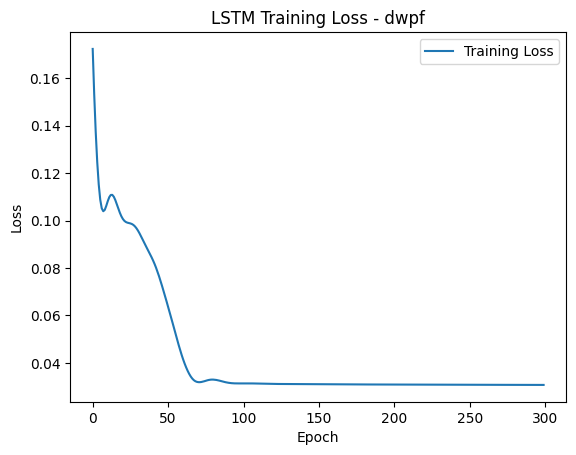

📊 Metrics for dwpf:
   R² Score : 0.7461
   MSE      : 0.0250
   MAE      : 0.1130


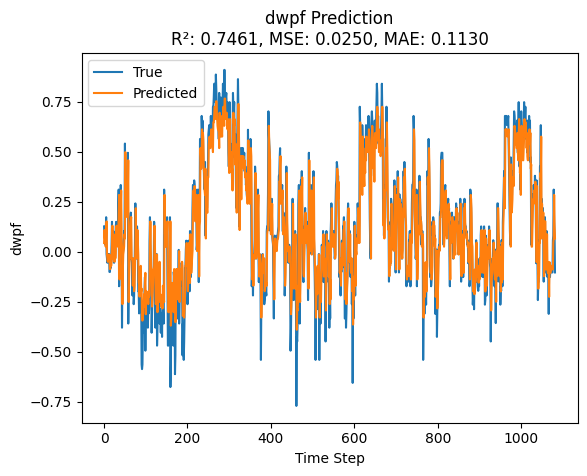


🔁 Training model for: relh
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.1131
Epoch 20/300, Loss: 0.0696
Epoch 30/300, Loss: 0.0701
Epoch 40/300, Loss: 0.0604
Epoch 50/300, Loss: 0.0586
Epoch 60/300, Loss: 0.0533
Epoch 70/300, Loss: 0.0473
Epoch 80/300, Loss: 0.0408
Epoch 90/300, Loss: 0.0346
Epoch 100/300, Loss: 0.0305
Epoch 110/300, Loss: 0.0287
Epoch 120/300, Loss: 0.0284
Epoch 130/300, Loss: 0.0282
Epoch 140/300, Loss: 0.0279
Epoch 150/300, Loss: 0.0277
Epoch 160/300, Loss: 0.0276
Epoch 170/300, Loss: 0.0275
Epoch 180/300, Loss: 0.0273
Epoch 190/300, Loss: 0.0272
Epoch 200/300, Loss: 0.0271
Epoch 210/300, Loss: 0.0271
Epoch 220/300, Loss: 0.0270
Epoch 230/300, Loss: 0.0269
Epoch 240/300, Loss: 0.0268
Epoch 250/300, Loss: 0.0268
Epoch 260/300, Loss: 0.0267
Epoch 270/300, Loss: 0.0266
Epoch 280/300, Loss: 0.0266
Epoch 290/300, Loss: 0.0265
Epoch 300/300, Loss: 0.0265


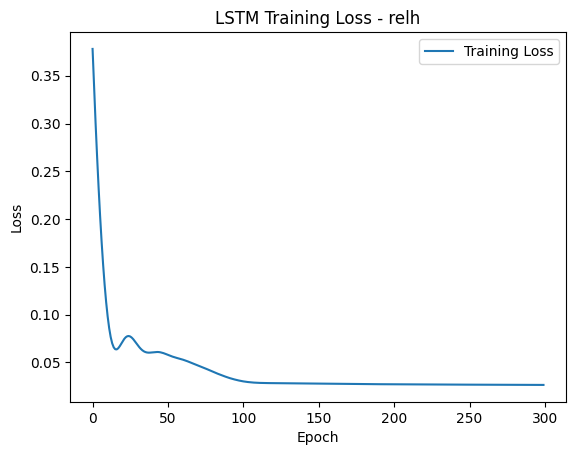

📊 Metrics for relh:
   R² Score : 0.6462
   MSE      : 0.0248
   MAE      : 0.1001


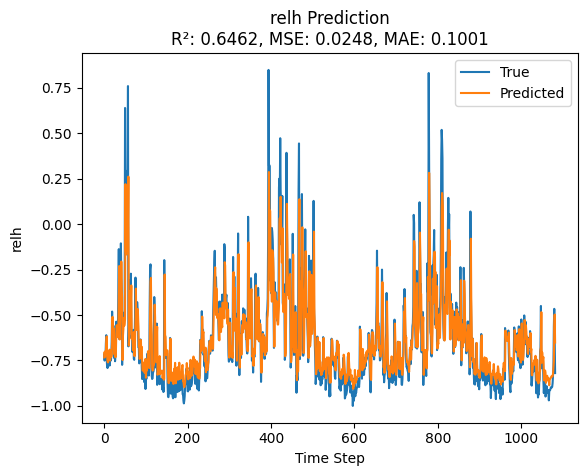


🔁 Training model for: drct
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.2923
Epoch 20/300, Loss: 0.2873
Epoch 30/300, Loss: 0.2864
Epoch 40/300, Loss: 0.2828
Epoch 50/300, Loss: 0.2771
Epoch 60/300, Loss: 0.2697
Epoch 70/300, Loss: 0.2627
Epoch 80/300, Loss: 0.2600
Epoch 90/300, Loss: 0.2594
Epoch 100/300, Loss: 0.2589
Epoch 110/300, Loss: 0.2583
Epoch 120/300, Loss: 0.2580
Epoch 130/300, Loss: 0.2578
Epoch 140/300, Loss: 0.2577
Epoch 150/300, Loss: 0.2576
Epoch 160/300, Loss: 0.2576
Epoch 170/300, Loss: 0.2576
Epoch 180/300, Loss: 0.2576
Epoch 190/300, Loss: 0.2575
Epoch 200/300, Loss: 0.2575
Epoch 210/300, Loss: 0.2575
Epoch 220/300, Loss: 0.2575
Epoch 230/300, Loss: 0.2575
Epoch 240/300, Loss: 0.2575
Epoch 250/300, Loss: 0.2575
Epoch 260/300, Loss: 0.2575
Epoch 270/300, Loss: 0.2574
Epoch 280/300, Loss: 0.2574
Epoch 290/300, Loss: 0.2574
Epoch 300/300, Loss: 0.2574


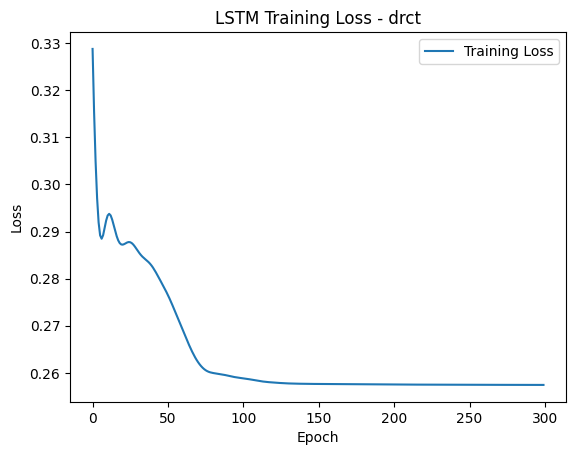

📊 Metrics for drct:
   R² Score : 0.1128
   MSE      : 0.2385
   MAE      : 0.3709


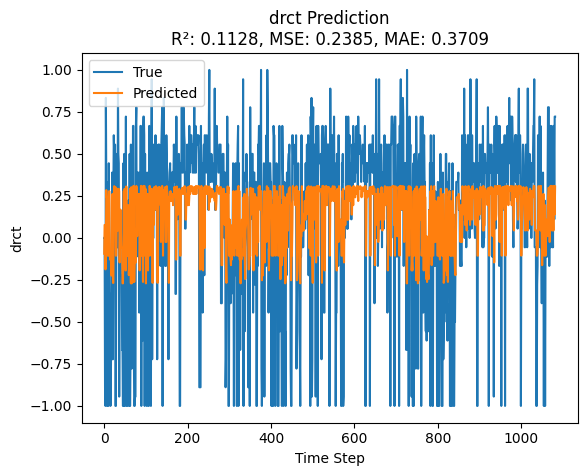


🔁 Training model for: sknt
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.0865
Epoch 20/300, Loss: 0.0764
Epoch 30/300, Loss: 0.0715
Epoch 40/300, Loss: 0.0695
Epoch 50/300, Loss: 0.0689
Epoch 60/300, Loss: 0.0684
Epoch 70/300, Loss: 0.0680
Epoch 80/300, Loss: 0.0676
Epoch 90/300, Loss: 0.0671
Epoch 100/300, Loss: 0.0664
Epoch 110/300, Loss: 0.0655
Epoch 120/300, Loss: 0.0643
Epoch 130/300, Loss: 0.0631
Epoch 140/300, Loss: 0.0619
Epoch 150/300, Loss: 0.0610
Epoch 160/300, Loss: 0.0606
Epoch 170/300, Loss: 0.0605
Epoch 180/300, Loss: 0.0605
Epoch 190/300, Loss: 0.0604
Epoch 200/300, Loss: 0.0604
Epoch 210/300, Loss: 0.0604
Epoch 220/300, Loss: 0.0604
Epoch 230/300, Loss: 0.0604
Epoch 240/300, Loss: 0.0604
Epoch 250/300, Loss: 0.0604
Epoch 260/300, Loss: 0.0604
Epoch 270/300, Loss: 0.0604
Epoch 280/300, Loss: 0.0604
Epoch 290/300, Loss: 0.0604
Epoch 300/300, Loss: 0.0604


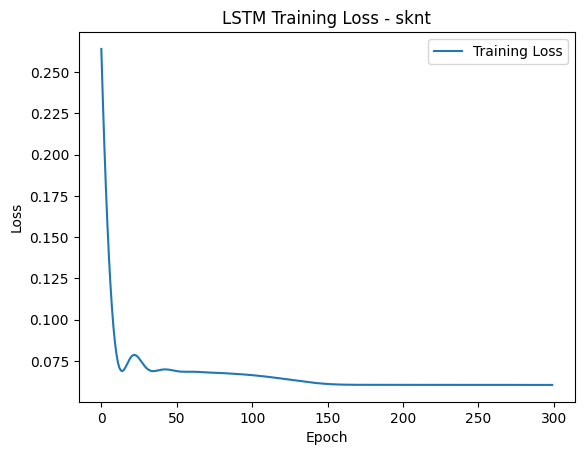

📊 Metrics for sknt:
   R² Score : 0.1229
   MSE      : 0.0587
   MAE      : 0.1913


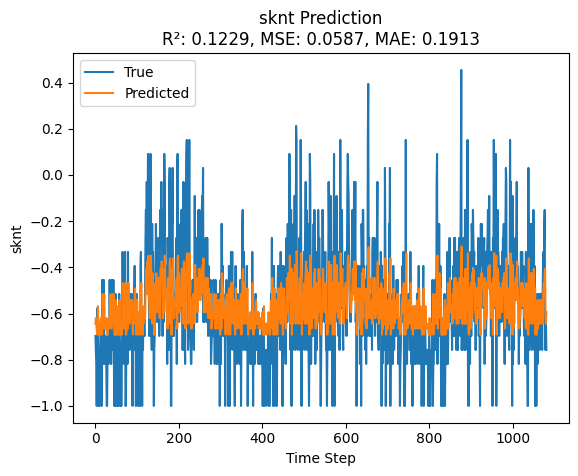


🔁 Training model for: alti
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.0713
Epoch 20/300, Loss: 0.0698
Epoch 30/300, Loss: 0.0664
Epoch 40/300, Loss: 0.0587
Epoch 50/300, Loss: 0.0454
Epoch 60/300, Loss: 0.0333
Epoch 70/300, Loss: 0.0330
Epoch 80/300, Loss: 0.0323
Epoch 90/300, Loss: 0.0321
Epoch 100/300, Loss: 0.0320
Epoch 110/300, Loss: 0.0320
Epoch 120/300, Loss: 0.0320
Epoch 130/300, Loss: 0.0319
Epoch 140/300, Loss: 0.0319
Epoch 150/300, Loss: 0.0319
Epoch 160/300, Loss: 0.0319
Epoch 170/300, Loss: 0.0319
Epoch 180/300, Loss: 0.0319
Epoch 190/300, Loss: 0.0319
Epoch 200/300, Loss: 0.0319
Epoch 210/300, Loss: 0.0319
Epoch 220/300, Loss: 0.0319
Epoch 230/300, Loss: 0.0319
Epoch 240/300, Loss: 0.0319
Epoch 250/300, Loss: 0.0319
Epoch 260/300, Loss: 0.0319
Epoch 270/300, Loss: 0.0319
Epoch 280/300, Loss: 0.0319
Epoch 290/300, Loss: 0.0319
Epoch 300/300, Loss: 0.0319


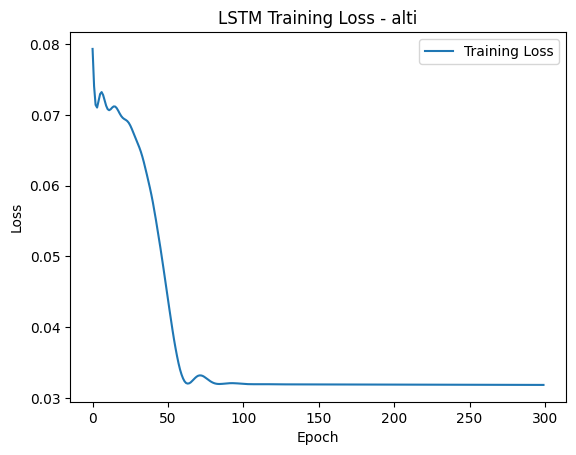

📊 Metrics for alti:
   R² Score : 0.5229
   MSE      : 0.0345
   MAE      : 0.1340


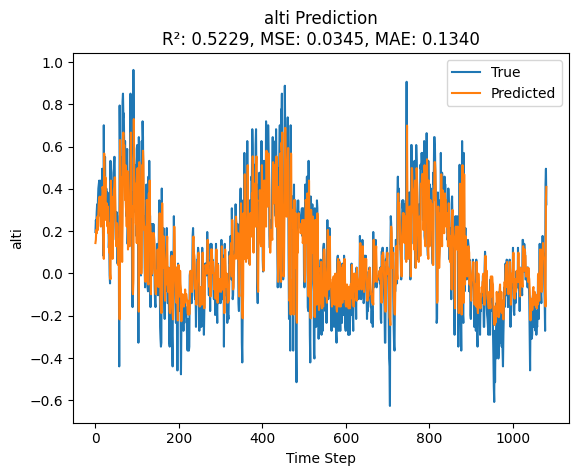


🔁 Training model for: mslp
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.0184
Epoch 20/300, Loss: 0.0228
Epoch 30/300, Loss: 0.0195
Epoch 40/300, Loss: 0.0182
Epoch 50/300, Loss: 0.0184
Epoch 60/300, Loss: 0.0181
Epoch 70/300, Loss: 0.0180
Epoch 80/300, Loss: 0.0180
Epoch 90/300, Loss: 0.0179
Epoch 100/300, Loss: 0.0178
Epoch 110/300, Loss: 0.0176
Epoch 120/300, Loss: 0.0173
Epoch 130/300, Loss: 0.0167
Epoch 140/300, Loss: 0.0158
Epoch 150/300, Loss: 0.0142
Epoch 160/300, Loss: 0.0117
Epoch 170/300, Loss: 0.0090
Epoch 180/300, Loss: 0.0074
Epoch 190/300, Loss: 0.0072
Epoch 200/300, Loss: 0.0073
Epoch 210/300, Loss: 0.0072
Epoch 220/300, Loss: 0.0072
Epoch 230/300, Loss: 0.0072
Epoch 240/300, Loss: 0.0072
Epoch 250/300, Loss: 0.0072
Epoch 260/300, Loss: 0.0072
Epoch 270/300, Loss: 0.0072
Epoch 280/300, Loss: 0.0072
Epoch 290/300, Loss: 0.0072
Epoch 300/300, Loss: 0.0072


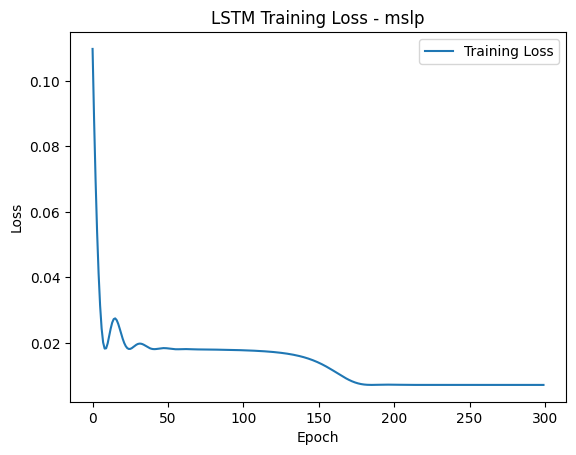

📊 Metrics for mslp:
   R² Score : 0.4814
   MSE      : 0.0108
   MAE      : 0.0652


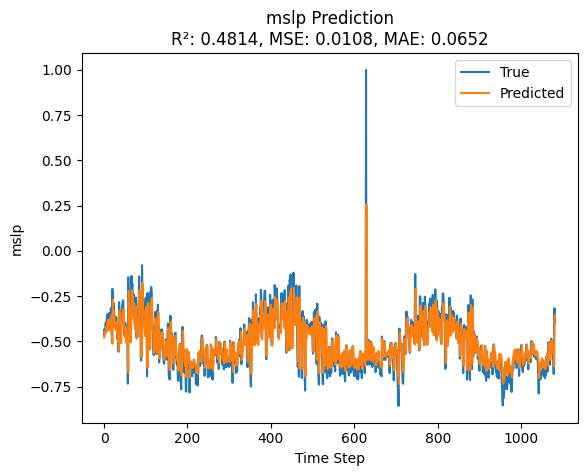


🔁 Training model for: vsby
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.0462
Epoch 20/300, Loss: 0.0041
Epoch 30/300, Loss: 0.0074
Epoch 40/300, Loss: 0.0009
Epoch 50/300, Loss: 0.0017
Epoch 60/300, Loss: 0.0008
Epoch 70/300, Loss: 0.0009
Epoch 80/300, Loss: 0.0008
Epoch 90/300, Loss: 0.0008
Epoch 100/300, Loss: 0.0007
Epoch 110/300, Loss: 0.0007
Epoch 120/300, Loss: 0.0007
Epoch 130/300, Loss: 0.0007
Epoch 140/300, Loss: 0.0007
Epoch 150/300, Loss: 0.0007
Epoch 160/300, Loss: 0.0007
Epoch 170/300, Loss: 0.0007
Epoch 180/300, Loss: 0.0007
Epoch 190/300, Loss: 0.0007
Epoch 200/300, Loss: 0.0007
Epoch 210/300, Loss: 0.0007
Epoch 220/300, Loss: 0.0007
Epoch 230/300, Loss: 0.0007
Epoch 240/300, Loss: 0.0007
Epoch 250/300, Loss: 0.0007
Epoch 260/300, Loss: 0.0007
Epoch 270/300, Loss: 0.0007
Epoch 280/300, Loss: 0.0007
Epoch 290/300, Loss: 0.0007
Epoch 300/300, Loss: 0.0007


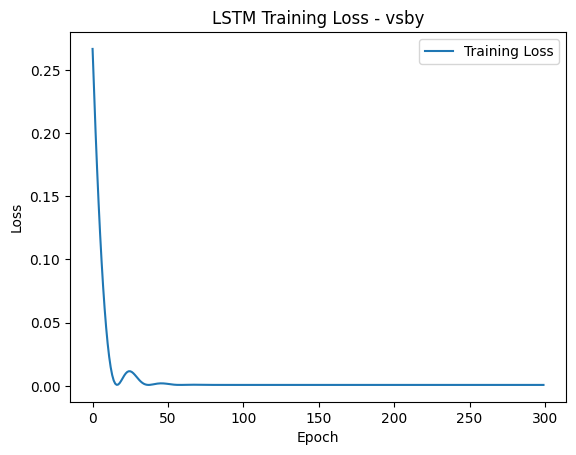

📊 Metrics for vsby:
   R² Score : -0.0036
   MSE      : 0.0002
   MAE      : 0.0012


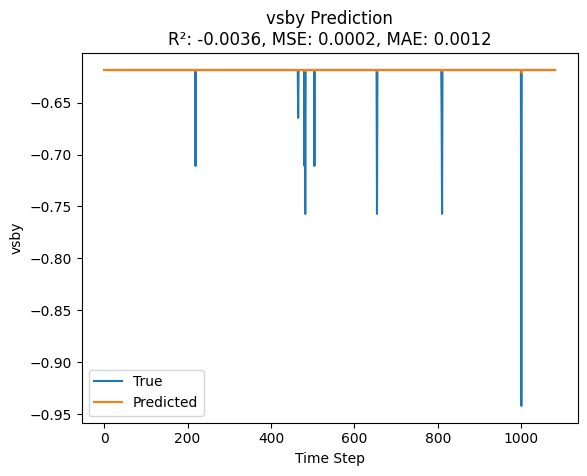


🔁 Training model for: temp_c
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.1837
Epoch 20/300, Loss: 0.1787
Epoch 30/300, Loss: 0.1779
Epoch 40/300, Loss: 0.1770
Epoch 50/300, Loss: 0.1728
Epoch 60/300, Loss: 0.1587
Epoch 70/300, Loss: 0.1210
Epoch 80/300, Loss: 0.0503
Epoch 90/300, Loss: 0.0138
Epoch 100/300, Loss: 0.0168
Epoch 110/300, Loss: 0.0127
Epoch 120/300, Loss: 0.0127
Epoch 130/300, Loss: 0.0122
Epoch 140/300, Loss: 0.0121
Epoch 150/300, Loss: 0.0120
Epoch 160/300, Loss: 0.0120
Epoch 170/300, Loss: 0.0119
Epoch 180/300, Loss: 0.0119
Epoch 190/300, Loss: 0.0119
Epoch 200/300, Loss: 0.0119
Epoch 210/300, Loss: 0.0119
Epoch 220/300, Loss: 0.0119
Epoch 230/300, Loss: 0.0119
Epoch 240/300, Loss: 0.0119
Epoch 250/300, Loss: 0.0119
Epoch 260/300, Loss: 0.0119
Epoch 270/300, Loss: 0.0119
Epoch 280/300, Loss: 0.0119
Epoch 290/300, Loss: 0.0119
Epoch 300/300, Loss: 0.0119


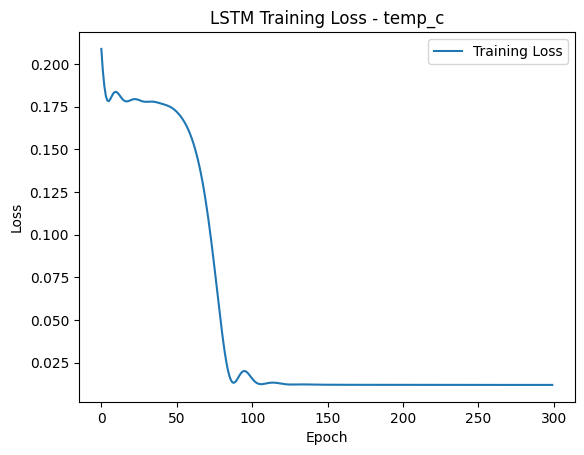

📊 Metrics for temp_c:
   R² Score : 0.9487
   MSE      : 0.0107
   MAE      : 0.0764


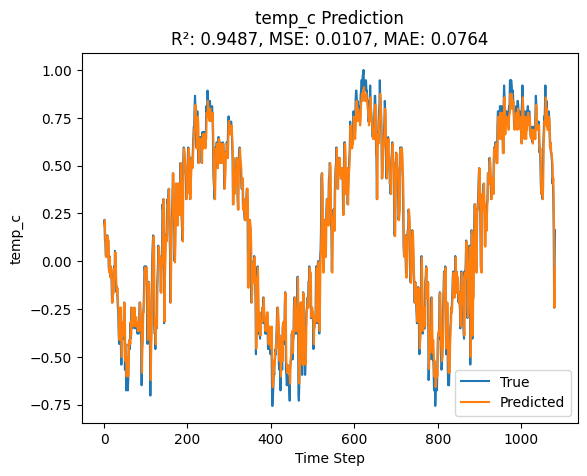

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assume normalize_data and LSTMRegressor are defined

sequence_length = 1
num_epochs = 300
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 1
backend = 'default.qubit'

for column in daily_max_temp.columns:
    print(f"\n🔁 Training model for: {column}")

    # Normalize and reshape
    data = daily_max_temp[column].values.reshape(-1, 1)
    data, scaler = normalize_data(data)
    
    # Create sequences
    def create_sequences(data, sequence_length):
        sequences, labels = [], []
        for i in range(len(data) - sequence_length):
            sequences.append(data[i:i + sequence_length])
            labels.append(data[i + sequence_length])
        return np.array(sequences), np.array(labels)
    
    X, y = create_sequences(data, sequence_length)
    
    # Train/test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    # Initialize model
    model = LSTMRegressor(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits, backend=backend)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_function = nn.MSELoss()
    
    # Train model
    loss_history = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_function(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    # Plot training loss
    plt.figure()
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'LSTM Training Loss - {column}')
    plt.legend()
    plt.show()
    
    # Predict and evaluate
    model.eval()
    y_pred = model(X_test_tensor).detach().numpy()

    # Evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"📊 Metrics for {column}:")
    print(f"   R² Score : {r2:.4f}")
    print(f"   MSE      : {mse:.4f}")
    print(f"   MAE      : {mae:.4f}")
    
    # Plot prediction
    plt.figure()
    plt.plot(range(len(y_test)), y_test, label='True')
    plt.plot(range(len(y_test)), y_pred, label='Predicted')
    plt.legend()
    plt.title(f'{column} Prediction\nR²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}')
    plt.xlabel('Time Step')
    plt.ylabel(column)
    plt.show()


# sequances lenth 1 and 1 qubit

In [7]:
data=daily_max_temp['temp_c'].values.reshape(-1,1)
data,scaler=normalize_data(data)


In [8]:
# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)
# Initialize variables
sequence_length =1

# Make a copy of the original DataFrame to update
updated_data = data.copy()

X, y = create_sequences(updated_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"data X train shape: {X_train.shape},data X test shape: {X_test.shape}")
print(f"data y train shape: {y_train.shape},data y test shape: {y_test.shape}")



data X train shape: (4325, 1, 1),data X test shape: (1082, 1, 1)
data y train shape: (4325, 1),data y test shape: (1082, 1)


In [9]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [10]:
# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0,n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits,n_qlayers=n_qlayers ,backend=backend)
        else:
            print("Using Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
        output = self.fc(lstm_out[:, -1])  # Predict next value
        return output

In [11]:
# Model parameters
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 1
backend = 'default.qubit'

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.1826
Epoch 20/300, Loss: 0.1763
Epoch 30/300, Loss: 0.1715
Epoch 40/300, Loss: 0.1627
Epoch 50/300, Loss: 0.1443
Epoch 60/300, Loss: 0.1097
Epoch 70/300, Loss: 0.0607
Epoch 80/300, Loss: 0.0202
Epoch 90/300, Loss: 0.0133
Epoch 100/300, Loss: 0.0142
Epoch 110/300, Loss: 0.0122
Epoch 120/300, Loss: 0.0124
Epoch 130/300, Loss: 0.0122
Epoch 140/300, Loss: 0.0122
Epoch 150/300, Loss: 0.0121
Epoch 160/300, Loss: 0.0121
Epoch 170/300, Loss: 0.0121
Epoch 180/300, Loss: 0.0120
Epoch 190/300, Loss: 0.0120
Epoch 200/300, Loss: 0.0120
Epoch 210/300, Loss: 0.0120
Epoch 220/300, Loss: 0.0120
Epoch 230/300, Loss: 0.0120
Epoch 240/300, Loss: 0.0120
Epoch 250/300, Loss: 0.0120
Epoch 260/300, Loss: 0.0120
Epoch 270/300, Loss: 0.0119
Epoch 280/300, Loss: 0.0119
Epoch 290/300, Loss: 0.0119
Epoch 300/300, Loss: 0.0119


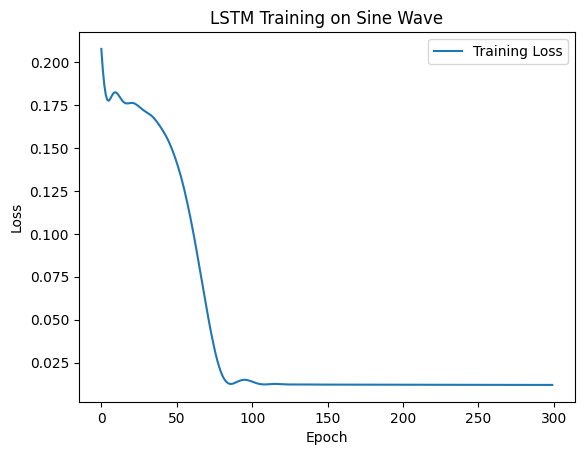

x test len:1082



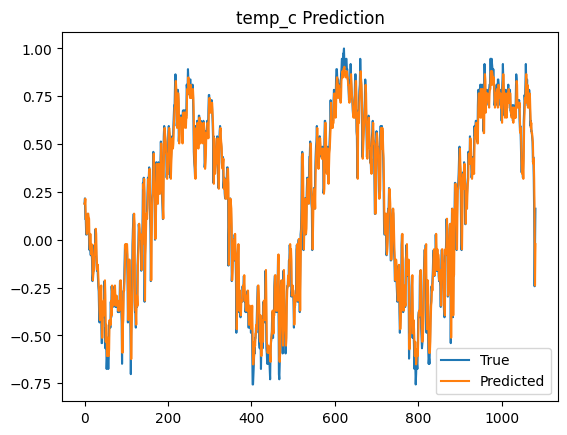

y test len:1082

y predicted len:1082

y orignal test len:1082

y orignal predicted len:1082



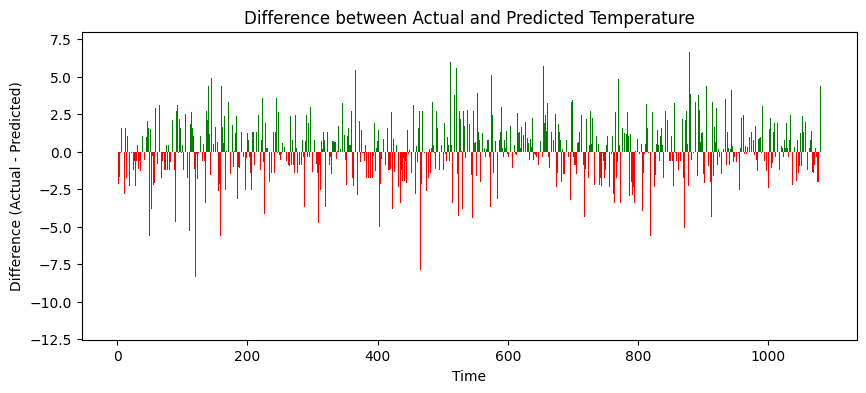

R² Score: 0.9486
Mean Squared Error (MSE): 4.5409
Mean Absolute Error (MAE): 1.5713
Root Mean Squared Error (RMSE): 2.1309


In [12]:
model = LSTMRegressor(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()
print(f'x test len:{len(X_test_tensor)}\n')
# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('temp_c Prediction')
plt.show()

print(f'y test len:{len(y_test)}\n')
print(f'y predicted len:{len(y_pred)}\n')

# Apply inverse scaling to bring data back to its original scale
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

print(f'y orignal test len:{len(y_test_original)}\n')
print(f'y orignal predicted len:{len(y_pred_original)}\n')

# Calculate the differences
diff = y_test_original - y_pred_original

plt.figure(figsize=(10, 4))

# Use colors to indicate positive and negative differences
colors = np.where(diff >= 0, "green", "red")

for i in range(len(diff)):
    plt.bar(i, diff[i], color=colors[i])

plt.xlabel("Time")
plt.ylabel("Difference (Actual - Predicted)")
plt.title("Difference between Actual and Predicted Temperature")
plt.show()

r2 = r2_score(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [13]:
predection=iterative_forecast_map(model,X_test_tensor,4,scaler)

C:\Users\muham\AppData\Local\Temp\ipykernel_25888\1708310602.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)
C:\Users\muham\AppData\Local\Temp\ipykernel_25888\1708310602.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)  # Add batch dimension
C:\Users\muham\AppData\Local\Temp\ipykernel_25888\1708310602.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tens

In [14]:
predection

{1: array([[[31.651775]],
 
        [[31.651775]],
 
        [[32.185844]],
 
        ...,
 
        [[30.579603]],
 
        [[22.861767]],
 
        [[27.309265]]], dtype=float32),
 2: array([[[31.637445]],
 
        [[31.637445]],
 
        [[32.1509  ]],
 
        ...,
 
        [[34.202003]],
 
        [[30.602882]],
 
        [[22.945272]]], dtype=float32),
 3: array([[[31.623657]],
 
        [[31.623657]],
 
        [[32.11733 ]],
 
        ...,
 
        [[36.119244]],
 
        [[34.08744 ]],
 
        [[30.625416]]], dtype=float32),
 4: array([[[31.610386]],
 
        [[31.610386]],
 
        [[32.08508 ]],
 
        ...,
 
        [[35.43995 ]],
 
        [[35.94467 ]],
 
        [[33.97718 ]]], dtype=float32)}

Prediction step: 1

Precision: 0.91
Recall:    0.78
F1 Score:  0.84


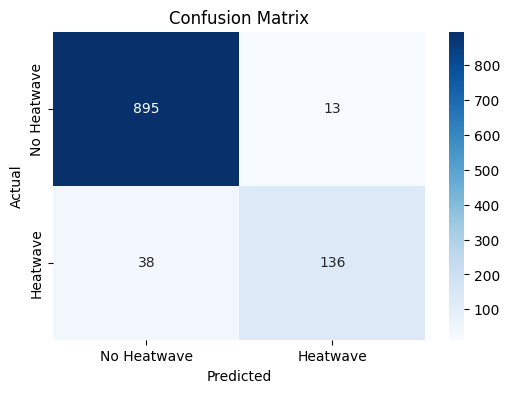

Prediction step: 2

Precision: 0.83
Recall:    0.71
F1 Score:  0.77


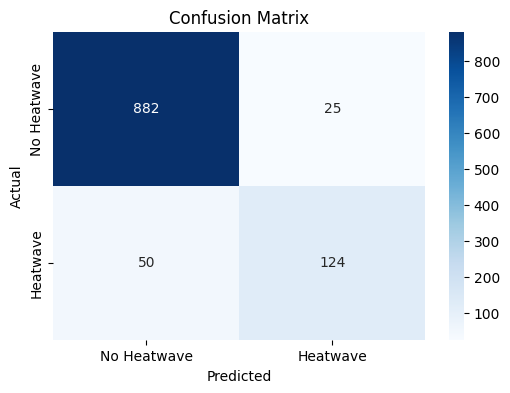

Prediction step: 3

Precision: 0.83
Recall:    0.55
F1 Score:  0.66


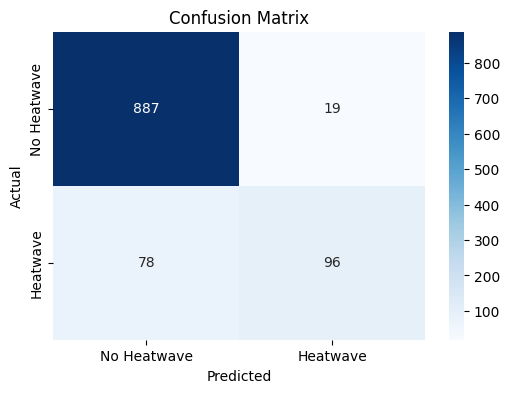

Prediction step: 4

Precision: 0.82
Recall:    0.40
F1 Score:  0.54


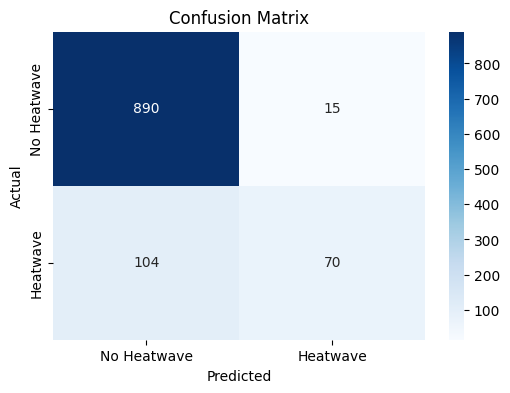

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set threshold based on 90th percentile of historical daily max temperatures
threshold = np.percentile(daily_max_temp["temp_c"], 90)

# Function to classify heatwave: 3 consecutive days above threshold
def classify_heatwave(data, threshold):
    # Convert to NumPy array if needed
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values.flatten()
    heatwave = [0] * len(data)
    for i in range(2, len(data)):
        if data[i] >= threshold and data[i-1] >= threshold and data[i-2] >= threshold:
            heatwave[i] = 1
            heatwave[i-1] = 1
            heatwave[i-2] = 1
    return heatwave

# Rescale y_test (if needed)
y_test_rescaled = scaler.inverse_transform(y_test)
actual_values = pd.DataFrame(y_test_rescaled, columns=['temp_c'])  # Make sure to label columns

# Initialize lists to store metrics
all_Precision = []
all_recall = []
all_f1score = []

# Loop through prediction_dict (step-ahead forecasts)
for step in range(1, len(predection) + 1):
    print(f"Prediction step: {step}\n")

    # Fix the shape of prediction data
    prediction_array = np.array(predection[step]).reshape(-1, 1)
    prediction = pd.DataFrame(prediction_array, columns=['temp_c'])

    # Slice actual values to align with prediction length
    temperory_actual_values = actual_values.iloc[step - 1: step - 1 + len(prediction)].copy()

    # Classify heatwaves
    actual_flags = classify_heatwave(temperory_actual_values['temp_c'], threshold)
    pred_flags = classify_heatwave(prediction['temp_c'], threshold)

    temperory_actual_values["day_included_heatwave"] = actual_flags
    prediction["day_included_heatwave"] = pred_flags

    # Evaluation
    y_true = temperory_actual_values['day_included_heatwave']
    y_pred = prediction['day_included_heatwave']

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    all_Precision.append(precision)
    all_recall.append(recall)
    all_f1score.append(f1)

    print(f'Precision: {precision:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'F1 Score:  {f1:.2f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heatwave', 'Heatwave'],
                yticklabels=['No Heatwave', 'Heatwave'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# 8 diminthion data sequances lenth 1 and 8 qubit

In [17]:
data = daily_max_temp.iloc[:, :8].values  # Extract first 8 columns as features
data

array([[  10.        ,   10.3       ,    0.        , ..., 1019.3       ,
          10.        ,   20.        ],
       [  17.        ,   13.1       ,    0.        , ..., 1015.3       ,
          10.        ,   21.11111111],
       [  20.        ,   14.29      ,  290.        , ..., 1016.8       ,
          10.        ,   21.66666667],
       ...,
       [  35.        ,   24.87      ,  200.        , ..., 1015.8       ,
          10.        ,   22.77777778],
       [  32.        ,   16.92      ,  310.        , ..., 1016.9       ,
          10.        ,   27.22222222],
       [  24.        ,    9.73      ,  310.        , ..., 1013.7       ,
          10.        ,   31.11111111]])

In [18]:
# Index of temp_c column
temp_c_index = daily_max_temp.columns.get_loc('temp_c')

# Normalize and create sequences
scaled_data, scaler = normalize_data(data)

# Define parameters
sequence_length = 1

# Create training data
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4325, 1, 8),data X test shape: (1082, 1, 8)
data y train shape: (4325, 8),data y test shape: (1082, 8)


In [19]:
X_train_tensor[:, :, temp_c_index]

tensor([[-0.3784],
        [-0.3243],
        [-0.2973],
        ...,
        [ 0.0541],
        [ 0.0270],
        [ 0.1081]])

In [20]:
# LSTMRegressor class with integrated classical LSTM
class LSTMRegressor_8_dim(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor_8_dim, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            # Use the build_lstm_model function to create the classical LSTM
            self.model, self.optimizer, self.criterion = build_lstm_model(input_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        if hasattr(self, 'model'):
            # Use the classical LSTM model
            return self.model(x)
        else:
            # Use the quantum LSTM
            lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
            output = self.fc(lstm_out[:, -1])  # Predict next values for all features
            return output

In [21]:
X_train_tensor

tensor([[[-0.4253, -0.8060, -1.0000,  ..., -0.2558, -0.6185, -0.3784]],

        [[-0.2644, -0.7406, -1.0000,  ..., -0.3581, -0.6185, -0.3243]],

        [[-0.1954, -0.7128,  0.6111,  ..., -0.3197, -0.6185, -0.2973]],

        ...,

        [[ 0.2184, -0.5933,  0.8333,  ..., -0.4936, -0.6185,  0.0541]],

        [[ 0.1724, -0.6108,  0.3889,  ..., -0.3734, -0.6185,  0.0270]],

        [[ 0.1494, -0.6659,  0.3889,  ..., -0.4322, -0.6185,  0.1081]]])

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 10/300 Train Loss: 0.1146 | Val Loss: 0.1245 Train R²: 0.3566 | Val R²: 0.4045
Epoch 20/300 Train Loss: 0.0417 | Val Loss: 0.0402 Train R²: 0.7658 | Val R²: 0.8080
Epoch 30/300 Train Loss: 0.0224 | Val Loss: 0.0219 Train R²: 0.8741 | Val R²: 0.8951
Epoch 40/300 Train Loss: 0.0153 | Val Loss: 0.0132 Train R²: 0.9138 | Val R²: 0.9367
Epoch 50/300 Train Loss: 0.0137 | Val Loss: 0.0121 Train R²: 0.9230 | Val R²: 0.9424
Epoch 60/300 Train Loss: 0.0131 | Val Loss: 0.0111 Train R²: 0.9263 | Val R²: 0.9467
Epoch 70/300 Train Loss: 0.0125 | Val Loss: 0.0111 Train R²: 0.9296 | Val R²: 0.9471
Epoch 80/300 Train Loss: 0.0120 | Val Loss: 0.0105 Train R²: 0.9325 | Val R²: 0.9496
Epoch 90/300 Train Loss: 0.0115 | Val Loss: 0.0103 Train R²: 0.9352 | Val R²: 0.9507
Epoch 100/300 Train Loss: 0.0112 | Val Loss: 0.0101 Train R²: 0.9371 | Val R²: 0.9519
Epoch 110/300 Train Loss: 0.0111 | Val Loss: 0.0100 Train 

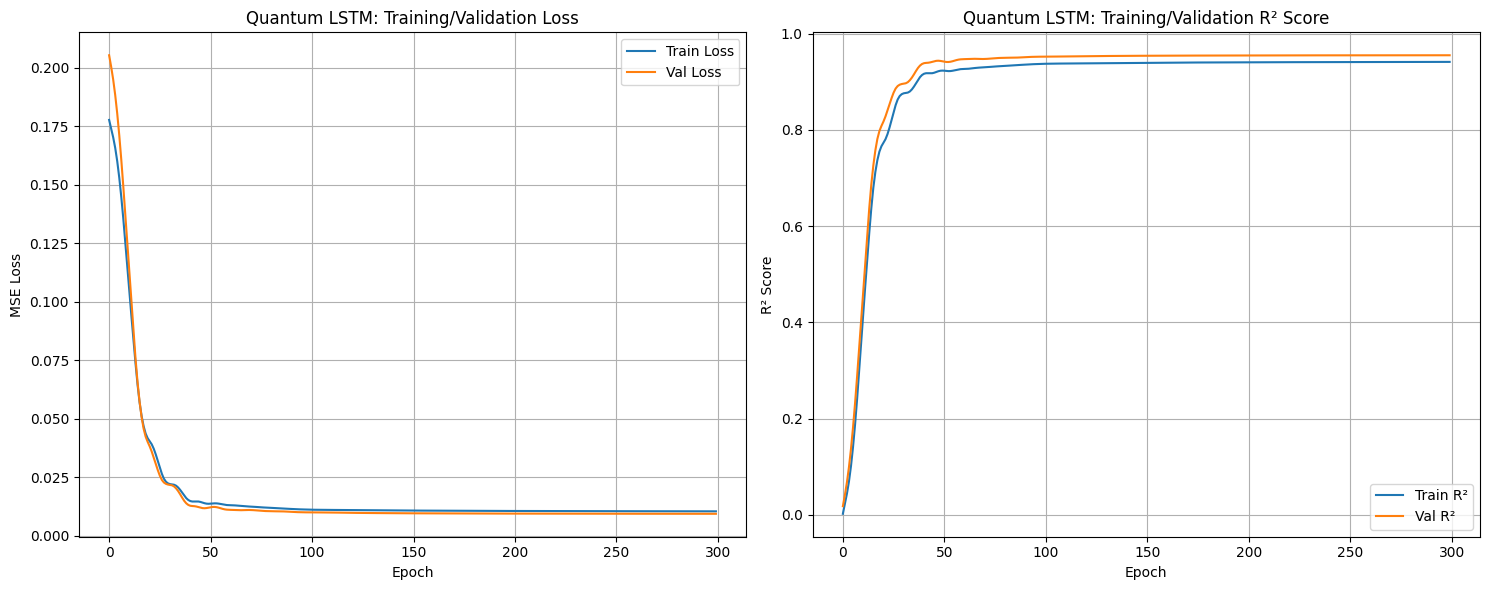

In [22]:
from sklearn.metrics import r2_score

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'
model = LSTMRegressor_8_dim(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs[:,temp_c_index], y_train_tensor[:,temp_c_index])
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np[:,temp_c_index], train_preds[:,temp_c_index], multioutput='uniform_average')
    
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs[:,temp_c_index], y_test_tensor[:,temp_c_index])
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np[:,temp_c_index], val_preds[:,temp_c_index], multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

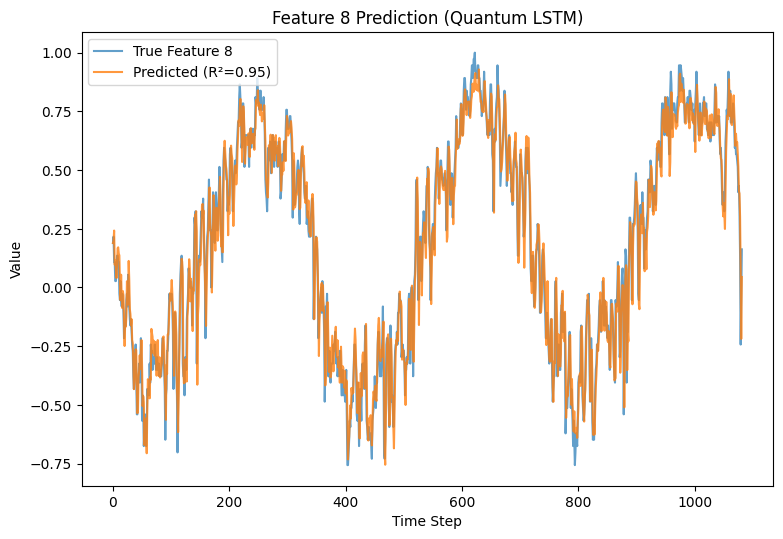


Quantum LSTM - Final Feature-wise Performance:
Feature 8: R² = 0.9549


In [23]:
# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    if i != temp_c_index:
        continue
    else:
        plt.subplot(4, 2, i+1)
        plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
        plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
        plt.title(f'Feature {i+1} Prediction (Quantum LSTM)')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    if i != temp_c_index:
        continue
    else:
        print(f"Feature {i+1}: R² = {r2:.4f}")

In [24]:
# Function to calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example: Assuming `model` is your PyTorch model
num_parameters = count_parameters(model)

print(f"The model has {num_parameters} trainable parameters.")

The model has 880 trainable parameters.


In [25]:
import numpy as np
import torch

def iterative_forecast_map(model, x_test, days_to_predict, scaler, device="cpu"):
    if isinstance(x_test, torch.Tensor):  # Ensure x_test is a NumPy array
        x_test = x_test.to(device).detach().numpy()

    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = torch.tensor(x_test[i], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dim

            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model(sequence)  # Forward pass instead of predict()
                prediction = prediction.squeeze(0).detach().cpu().numpy()  # Convert back to NumPy
                sequence = np.vstack((sequence.squeeze(0).cpu().numpy()[1:], prediction))  # Update sequence
                sequence = torch.tensor(sequence, dtype=torch.float32, device=device).unsqueeze(0)  # Convert back

            # Final prediction for the current step
            final_prediction = model(sequence).detach().cpu().numpy()
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict

In [26]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)  # Move model to the correct device
# predictions = iterative_forecast_map(model, X_test_tensor, 4, scaler, device=device)


In [27]:
optimize_predictions_10 = iterative_forecast_map(model, X_test_tensor, 4, scaler)
optimize_predictions_10

{1: array([[[  35.040737,   44.841724,  172.53423 , ..., 1026.7434  ,
            26.893467,   31.669598]],
 
        [[  35.03198 ,   44.892685,  172.7065  , ..., 1026.7385  ,
            26.875862,   31.864416]],
 
        [[  34.975174,   44.927467,  173.57251 , ..., 1026.7593  ,
            26.752686,   32.757576]],
 
        ...,
 
        [[  35.265972,   44.860764,  170.74068 , ..., 1026.667   ,
            27.26217 ,   29.20487 ]],
 
        [[  36.049007,   44.18667 ,  168.9504  , ..., 1025.9594  ,
            28.063618,   23.272963]],
 
        [[  35.411667,   44.57518 ,  170.97186 , ..., 1026.3837  ,
            27.276365,   28.689913]]], dtype=float32),
 2: array([[[  34.98045 ,   44.368305,  172.94746 , ..., 1026.2299  ,
            26.946493,   31.043392]],
 
        [[  34.968647,   44.38832 ,  173.07155 , ..., 1026.242   ,
            26.924229,   31.213932]],
 
        [[  34.91541 ,   44.483803,  173.67236 , ..., 1026.2987  ,
            26.82113 ,   32.013855]],
 
 

In [28]:
y_8_test_rescaled = scaler.inverse_transform(y_8_test)
y_8_test_rescaled

array([[  34.        ,   14.14      ,  180.        , ..., 1011.2       ,
          10.        ,   31.66666667],
       [  32.        ,   12.68      ,  180.        , ..., 1012.4       ,
          10.        ,   32.22222222],
       [  32.        ,   14.4       ,   20.        , ..., 1012.        ,
          10.        ,   30.        ],
       ...,
       [  35.        ,   24.87      ,  200.        , ..., 1015.8       ,
          10.        ,   22.77777778],
       [  32.        ,   16.92      ,  310.        , ..., 1016.9       ,
          10.        ,   27.22222222],
       [  24.        ,    9.73      ,  310.        , ..., 1013.7       ,
          10.        ,   31.11111111]])

prediction num 1

Precision: 0.91
Recall: 0.75
F1 Score: 0.82


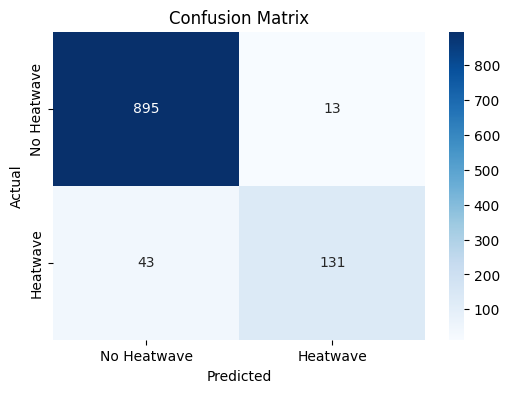

prediction num 2

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


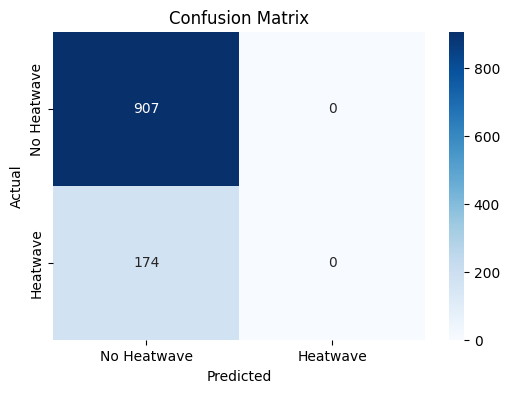

prediction num 3

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


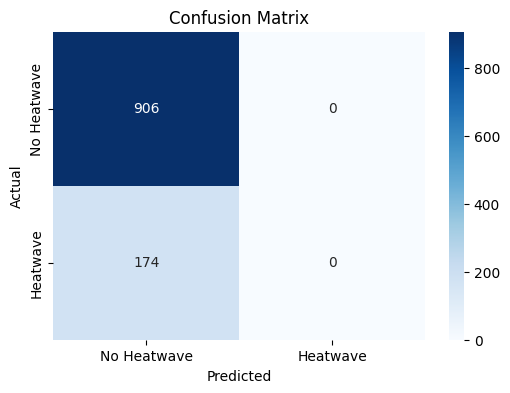

prediction num 4

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


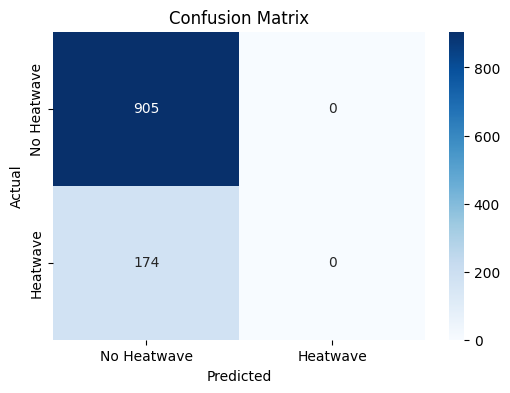

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

threshold = np.percentile(daily_max_temp["temp_c"], 90)

# Function to classify each day based on specified criteria
def classify_heatwave(data, threshold):
    # Convert data to NumPy array if it's a DataFrame or Series
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values
    heatwave = [0] * len(data)  # Initialize the heatwave list with zeros
    for i in range(2, len(data)):
        if data[i] >= threshold:
            if data[i-1] >= threshold and data[i-2] >= threshold:
                heatwave[i] = 1
                heatwave[i-1] = 1
                heatwave[i-2] = 1
            else:
                heatwave[i] = 0
        else:
            heatwave[i] = 0
    return heatwave

# Example actual values (replace with your actual data)
actual_values = pd.DataFrame(y_8_test_rescaled).copy()
predictions=optimize_predictions_10
# Example prediction_dict (replace with your actual prediction_dict)
prediction_dict = optimize_predictions_10

# Initialize lists to store results
all_Precision = []
all_recall = []
all_f1score = []

# Loop through each horizon in prediction_dict
for step in range(1, len(prediction_dict) + 1):
    print(f"prediction num {step}\n")
    
    # Get predictions for the current horizon
    prediction = pd.DataFrame(predictions[step].reshape(len(actual_values) - (step - 1), 8))
    
    # Slice actual values to align with predictions
    temperory_actual_values = actual_values.iloc[step - 1:].copy()
    
    # Classify heatwave for actual values
    actual_heatwave_flags = classify_heatwave(temperory_actual_values[temp_c_index], threshold)
    temperory_actual_values["day_included_heatwave"] = actual_heatwave_flags
    
    # Classify heatwave for predicted values
    prediction_values_heatwave_flags = classify_heatwave(prediction[temp_c_index], threshold)
    prediction["day_included_heatwave"] = prediction_values_heatwave_flags
    
    # Extract heatwave columns
    y_true = temperory_actual_values['day_included_heatwave']
    y_pred = prediction['day_included_heatwave']
    
    # Compute evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Append metrics to lists
    all_Precision.append(precision)
    all_recall.append(recall)
    all_f1score.append(f1)
    
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heatwave', 'Heatwave'], yticklabels=['No Heatwave', 'Heatwave'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()